### [Univariate Time series forecasting using RNN](https://www.tensorflow.org/beta/tutorials/text/time_series)

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

In [3]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [4]:
mpl.style.use('ggplot')
mpl.rcParams['figure.figsize'] = (10, 6)
mpl.rcParams['axes.grid'] = False

#### Get the data

In [5]:
zip_path = tf.keras.utils.get_file(origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
                                  fname='jena_climate_2009_2016.csv.zip',
                                  extract=True)

In [6]:
csv_path, _ = os.path.splitext(zip_path)

In [7]:
df = pd.read_csv(csv_path)

In [8]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


#### Prepare data

In [9]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []
    
    start_index += history_size
    if end_index is None:
        end_index = len(dataset) - target_size
        
    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
        
    return np.array(data), np.array(labels)

Split criterion and seed setting!

In [10]:
TRAIN_SPLIT = 300000

In [11]:
tf.random.set_seed(13)

**Univariate TS:** Make predictions using only a single feature. ( _in this case, temperature!_ )

In [12]:
data = df['T (degC)']
data.index = df['Date Time']
data.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

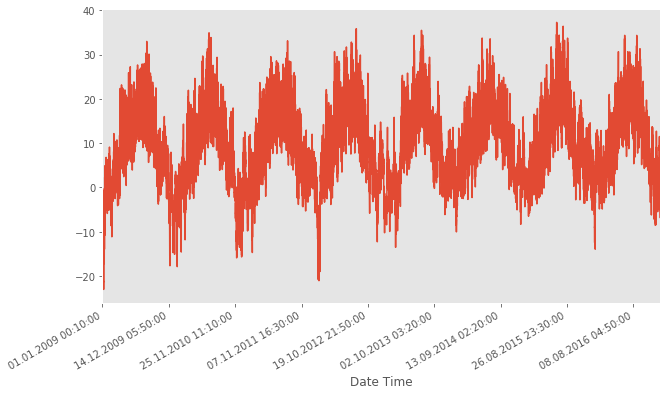

In [13]:
data.plot(subplots=True);

In [14]:
data = data.values

**Normalization** by subtracting the mean and dividing by the standard deviation.

In [15]:
train_mean = data[:TRAIN_SPLIT].mean()
train_std = data[:TRAIN_SPLIT].std()

In [16]:
data = (data - train_mean) / train_std

Prepare the data for univariate model!

In [17]:
PAST_HIST = 20
FUTURE_TARGET = 0

In [18]:
X_train, y_train = univariate_data(data, 0, TRAIN_SPLIT, PAST_HIST, FUTURE_TARGET)
X_test, y_test = univariate_data(data, TRAIN_SPLIT, None, PAST_HIST, FUTURE_TARGET)

What it looks like?

In [19]:
print('Single window of past history:\n{}'.format(X_train[0]))
print('\nTarget temperature to predict: {}'.format(y_train[0]))

Single window of past history:
[[-1.99766294]
 [-2.04281897]
 [-2.05439744]
 [-2.0312405 ]
 [-2.02660912]
 [-2.00113649]
 [-1.95134907]
 [-1.95134907]
 [-1.98492663]
 [-2.04513467]
 [-2.08334362]
 [-2.09723778]
 [-2.09376424]
 [-2.09144854]
 [-2.07176515]
 [-2.07176515]
 [-2.07639653]
 [-2.08913285]
 [-2.09260639]
 [-2.10418486]]

Target temperature to predict: -2.1041848598100876


#### An example!

In [20]:
def create_time_steps(length):
    time_steps = []
    for i in range(-length, 0, 1):
        time_steps.append(i)
    return time_steps

A helper function to plot graphs!

In [21]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'kx', 'bo']
    time_steps = create_time_steps(plot_data[0].shape[0])
    
    if delta:
        future = delta
    else:
        future = 0
        
    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=5, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Steps')
    plt.legend()
    return plt

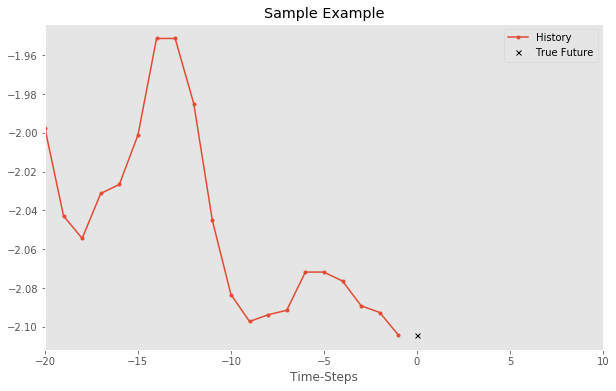

In [22]:
show_plot([X_train[0], y_train[0]], 0, 'Sample Example');

#### RNN

Shuffle, batch and cache the dataset!

In [23]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

In [24]:
train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

In [25]:
test = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test = test.batch(BATCH_SIZE).repeat()

Define the model.

In [26]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=X_train.shape[-2:]),
    tf.keras.layers.Dense(1)
])

In [27]:
model.compile(optimizer='adam',
             loss='mae')

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 8)                 320       
_________________________________________________________________
dense (Dense)                (None, 1)                 9         
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________


Make sample prediction to check our model!

In [29]:
for x, y in test.take(1):
    print(model.predict(x).shape)

(256, 1)


It's time for some training!

In [30]:
STEPS = 200
EPOCHS = 10

In [31]:
hist = model.fit(train, epochs=EPOCHS, steps_per_epoch=STEPS, validation_data=test, validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 11s 53ms/step - loss: 0.4075 - val_loss: 0.1351
Epoch 2/10
200/200 [==============================] - 5s 25ms/step - loss: 0.1118 - val_loss: 0.0359
Epoch 3/10
200/200 [==============================] - 5s 27ms/step - loss: 0.0489 - val_loss: 0.0290
Epoch 4/10
200/200 [==============================] - 5s 23ms/step - loss: 0.0443 - val_loss: 0.0258
Epoch 5/10
200/200 [==============================] - 5s 25ms/step - loss: 0.0299 - val_loss: 0.0235
Epoch 6/10
200/200 [==============================] - 5s 27ms/step - loss: 0.0317 - val_loss: 0.0224
Epoch 7/10
200/200 [==============================] - 5s 24ms/step - loss: 0.0286 - val_loss: 0.0206
Epoch 8/10
200/200 [==============================] - 5s 23ms/step - loss: 0.0263 - val_loss: 0.0199
Epoch 9/10
200/200 [==============================] - 4s 22ms/step - loss: 0.0254 - val_loss: 0.0182
Epoch 10/10
200/200 [==========================

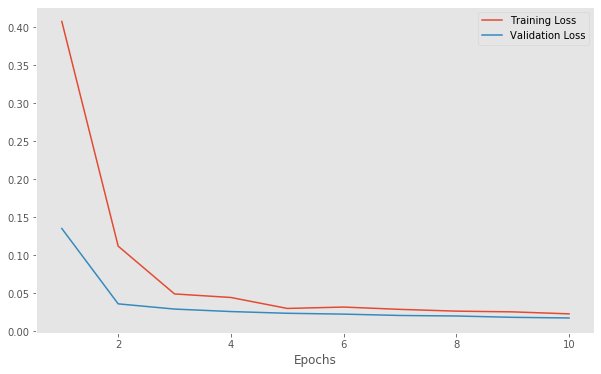

In [32]:
plt.plot(range(1, EPOCHS+1), hist.history['loss'], label='Training Loss')
plt.plot(range(1, EPOCHS+1), hist.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs');

Make predictions!

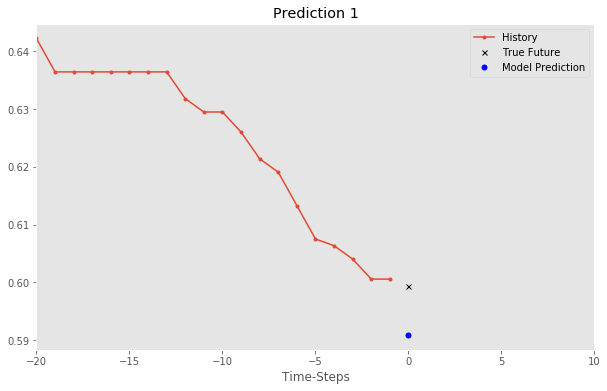

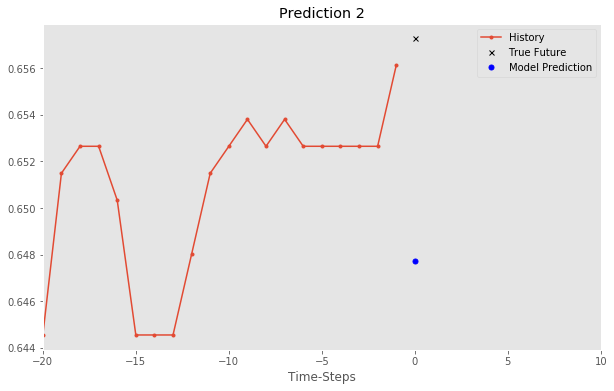

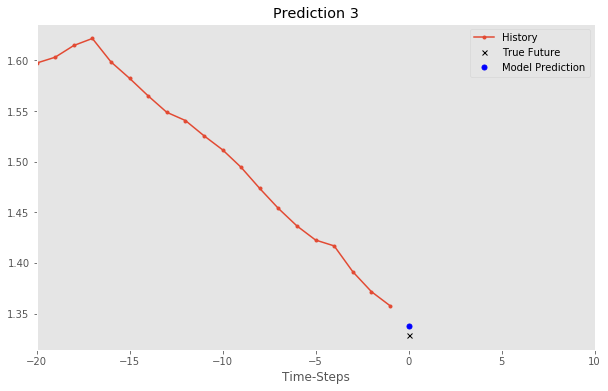

In [33]:
for i, (x, y) in enumerate(test.take(3)):
    plot = show_plot([x[0].numpy(), y[0].numpy(), model.predict(x)[0]], 0, f'Prediction {i+1}')
    plot.show()